- 본 코드는 ImageNet1k 데이터 일부를 ResNet 모델에서 DyT로 대체하는 Experiment를 수행합니다
1. ResNet의 BatchNormalization을 그대로 사용하여 학습
2. DyT로 대체하여 학습

## Batch Normalization

In [ ]:
'''
pip install datasets
pip install timm

'''
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import time
from datasets import load_dataset
from PIL import Image
import pandas as pd

# HuggingFace에서 mini-ImageNet 로드
dataset = load_dataset("timm/mini-imagenet")

# 사용자 정의 Dataset 클래스
class HuggingfaceMiniImageNet(Dataset):
    def __init__(self, hf_split, transform=None):
        self.data = hf_split
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label


def get_mini_imagenet_loaders(batch_size=128, num_workers=4):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = HuggingfaceMiniImageNet(dataset['train'], transform=train_transform)
    val_dataset = HuggingfaceMiniImageNet(dataset['validation'], transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader


def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return 100. * correct / total


def train_resnet50_mini_imagenet():
    device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = get_mini_imagenet_loaders()

    model = models.resnet50(weights=None) 
    model.fc = nn.Linear(model.fc.in_features, 100)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.05, momentum=0.9, weight_decay=0.0001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    # 결과 저장용 리스트
    losses = []
    val_accuracies = []
    epoch_times = []

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start = time.time()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        val_acc = evaluate(model, val_loader, device)

        epoch_time = time.time() - start
        avg_loss = running_loss / len(train_loader)
        
        # 결과 저장
        losses.append(avg_loss)
        val_accuracies.append(val_acc)
        epoch_times.append(epoch_time)

        print(f"[BN] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {epoch_time:.2f}s")

    torch.save(model.state_dict(), "resnet50_bn_mini_imagenet.pth")

    print_training_summary(losses, val_accuracies, epoch_times)


# 학습 후 결과 정리
def print_training_summary(losses, val_accuracies, epoch_times):
    df = pd.DataFrame({
        'Epoch': list(range(1, len(losses)+1)),
        'Loss': losses,
        'Val_Accuracy (%)': val_accuracies,
        'Time (s)': epoch_times
    })
    print("\n📊 Training Summary:")
    print(df.to_string(index=False))

    # (선택) CSV로 저장하고 싶다면
    df.to_csv("resnet50_bn_summary.csv", index=False)

if __name__ == '__main__':
    train_resnet50_mini_imagenet()
    

/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 1/30, Loss: 4.7532, Val Acc: 2.67%, Time: 127.83s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 2/30, Loss: 4.4892, Val Acc: 6.74%, Time: 128.14s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 3/30, Loss: 4.3600, Val Acc: 10.00%, Time: 126.88s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 4/30, Loss: 4.1816, Val Acc: 14.13%, Time: 127.98s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 5/30, Loss: 4.0111, Val Acc: 16.78%, Time: 126.97s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 6/30, Loss: 3.8769, Val Acc: 21.74%, Time: 127.97s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 7/30, Loss: 3.7432, Val Acc: 25.01%, Time: 127.79s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 8/30, Loss: 3.6230, Val Acc: 25.40%, Time: 126.88s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 9/30, Loss: 3.5096, Val Acc: 24.08%, Time: 126.47s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 10/30, Loss: 3.4108, Val Acc: 33.70%, Time: 128.45s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 11/30, Loss: 3.3129, Val Acc: 35.32%, Time: 127.21s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 12/30, Loss: 3.2237, Val Acc: 39.79%, Time: 126.80s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 13/30, Loss: 3.1403, Val Acc: 39.94%, Time: 126.70s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 14/30, Loss: 3.0662, Val Acc: 41.70%, Time: 126.82s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 15/30, Loss: 3.0216, Val Acc: 44.95%, Time: 127.03s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 16/30, Loss: 2.9138, Val Acc: 45.68%, Time: 127.39s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 17/30, Loss: 2.8517, Val Acc: 47.20%, Time: 128.12s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 18/30, Loss: 2.7873, Val Acc: 51.66%, Time: 127.53s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 19/30, Loss: 2.7233, Val Acc: 52.47%, Time: 127.21s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 20/30, Loss: 2.6552, Val Acc: 55.71%, Time: 127.39s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 21/30, Loss: 2.5970, Val Acc: 58.04%, Time: 127.76s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 22/30, Loss: 2.5438, Val Acc: 59.66%, Time: 128.62s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 23/30, Loss: 2.4872, Val Acc: 60.09%, Time: 127.20s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 24/30, Loss: 2.4316, Val Acc: 63.17%, Time: 128.02s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 25/30, Loss: 2.3818, Val Acc: 63.32%, Time: 129.19s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 26/30, Loss: 2.3447, Val Acc: 64.95%, Time: 129.54s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 27/30, Loss: 2.3174, Val Acc: 65.34%, Time: 127.80s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 28/30, Loss: 2.2799, Val Acc: 66.44%, Time: 129.03s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 29/30, Loss: 2.2610, Val Acc: 66.67%, Time: 127.72s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[BN] Epoch 30/30, Loss: 2.2495, Val Acc: 66.76%, Time: 127.12s

📊 Training Summary:
 Epoch     Loss  Val_Accuracy (%)   Time (s)
     1 4.753234              2.67 127.831068
     2 4.489207              6.74 128.143831
     3 4.359990             10.00 126.883666
     4 4.181623             14.13 127.982582
     5 4.011063             16.78 126.968091
     6 3.876912             21.74 127.973811
     7 3.743233             25.01 127.786729
     8 3.623030             25.40 126.881715
     9 3.509597             24.08 126.468083
    10 3.410773             33.70 128.446500
    11 3.312937             35.32 127.214460
    12 3.223672             39.79 126.801852
    13 3.140250             39.94 126.698622
    14 3.066198             41.70 126.819443
    15 3.021570             44.95 127.029582
    16 2.913812             45.68 127.390924
    17 2.851659             47.20 128.116903
    18 2.787298             51.66 127.527914
    19 2.723321             52.47 127.205888
    20 2.655238 

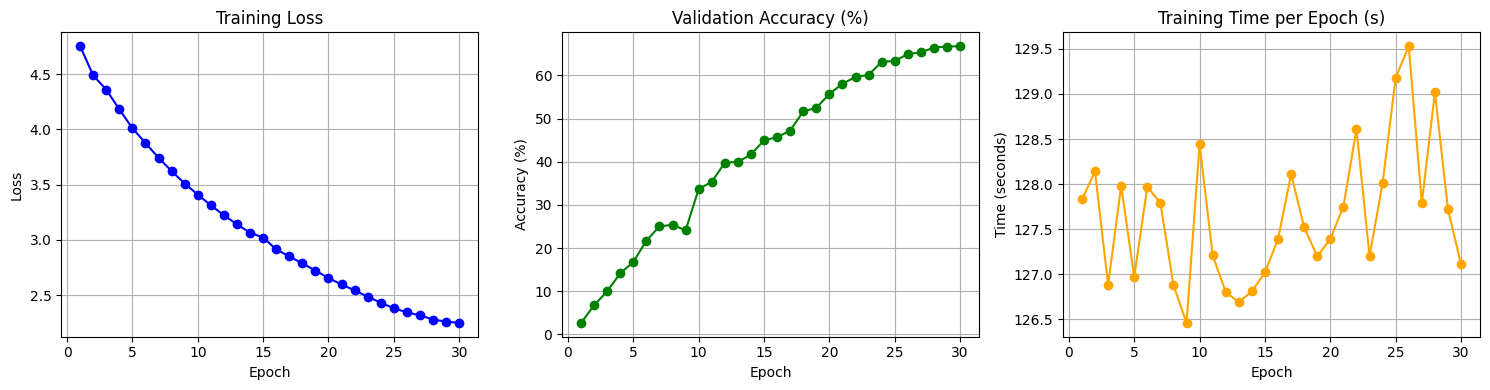

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# CSV 없이 직접 값 입력
data = {
    'Epoch': list(range(1, 31)),
    'Loss': [
        4.753234, 4.489207, 4.359990, 4.181623, 4.011063, 3.876912, 3.743233, 3.623030, 3.509597, 3.410773,
        3.312937, 3.223672, 3.140250, 3.066198, 3.021570, 2.913812, 2.851659, 2.787298, 2.723321, 2.655238,
        2.597036, 2.543831, 2.487162, 2.431552, 2.381760, 2.344657, 2.317441, 2.279939, 2.261039, 2.249488
    ],
    'Val_Accuracy': [
        2.67, 6.74, 10.00, 14.13, 16.78, 21.74, 25.01, 25.40, 24.08, 33.70,
        35.32, 39.79, 39.94, 41.70, 44.95, 45.68, 47.20, 51.66, 52.47, 55.71,
        58.04, 59.66, 60.09, 63.17, 63.32, 64.95, 65.34, 66.44, 66.67, 66.76
    ],
    'Time': [
        127.83, 128.14, 126.88, 127.98, 126.97, 127.97, 127.79, 126.88, 126.46, 128.44,
        127.21, 126.80, 126.69, 126.81, 127.02, 127.39, 128.11, 127.52, 127.20, 127.39,
        127.75, 128.61, 127.20, 128.01, 129.18, 129.53, 127.79, 129.02, 127.72, 127.11
    ]
}

# DataFrame 생성
df = pd.DataFrame(data)

# 시각화
plt.figure(figsize=(15, 4))

# Loss Plot
plt.subplot(1, 3, 1)
plt.plot(df['Epoch'], df['Loss'], marker='o', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Accuracy Plot
plt.subplot(1, 3, 2)
plt.plot(df['Epoch'], df['Val_Accuracy'], marker='o', color='green')
plt.title('Validation Accuracy (%)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid(True)

# Time Plot
plt.subplot(1, 3, 3)
plt.plot(df['Epoch'], df['Time'], marker='o', color='orange')
plt.title('Training Time per Epoch (s)')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.grid(True)

plt.tight_layout()
plt.show()


## DyT

In [2]:
# pip install datasets timm

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
import time
from datasets import load_dataset
from PIL import Image
import pandas as pd

# DyT 정의
class DyT(nn.Module):
    def __init__(self, num_features, alpha_init=1.0):
        super(DyT, self).__init__()
        self.alpha = nn.Parameter(torch.tensor(alpha_init))
        self.weight = nn.Parameter(torch.ones(num_features))
        self.bias = nn.Parameter(torch.zeros(num_features))

    def forward(self, x):
        return torch.tanh(self.alpha * x) * self.weight.view(1, -1, 1, 1) + self.bias.view(1, -1, 1, 1)

# BN -> DyT 대체 함수
def replace_bn_with_dyt(model):
    for name, module in model.named_children():
        if isinstance(module, nn.BatchNorm2d):
            num_features = module.num_features
            device = next(module.parameters()).device
            setattr(model, name, DyT(num_features).to(device))
        else:
            replace_bn_with_dyt(module)
    return model

# HuggingFace에서 mini-ImageNet 로드
dataset = load_dataset("timm/mini-imagenet")

class HuggingfaceMiniImageNet(Dataset):
    def __init__(self, hf_split, transform=None):
        self.data = hf_split
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]['image']
        label = self.data[idx]['label']
        image = image.convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

def get_mini_imagenet_loaders(batch_size=128, num_workers=4):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.AutoAugment(),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = HuggingfaceMiniImageNet(dataset['train'], transform=train_transform)
    val_dataset = HuggingfaceMiniImageNet(dataset['validation'], transform=val_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

    return train_loader, val_loader

def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            correct += predicted.eq(targets).sum().item()
            total += targets.size(0)
    return 100. * correct / total

def extract_alpha_values(model):
    alpha_values = []
    for i, module in enumerate(model.modules()):
        if isinstance(module, DyT):
            alpha_values.append(module.alpha.item())
    return alpha_values

def train_resnet50_dyt_mini_imagenet():
    device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
    train_loader, val_loader = get_mini_imagenet_loaders()

    # ResNet50 모델 로드
    model = models.resnet50(weights=None) 
    model.fc = nn.Linear(model.fc.in_features, 100)
    model = model.to(device)
    model = replace_bn_with_dyt(model)

    dyt_params, other_params = [], []
    for name, param in model.named_parameters():
        if 'alpha' in name or 'bias' in name:
            dyt_params.append(param)
        else:
            other_params.append(param)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.SGD([
        {'params': dyt_params, 'weight_decay': 0.0},
        {'params': other_params, 'weight_decay': 0.0001},
    ], lr=0.05, momentum=0.9)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

    num_epochs = 30
    losses, val_accuracies, alpha_history = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        start = time.time()
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        val_acc = evaluate(model, val_loader, device)

        # 저장
        losses.append(avg_loss)
        val_accuracies.append(val_acc)
        alpha_values = extract_alpha_values(model)
        alpha_history.append(alpha_values)

        print(f"[DyT] Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Acc: {val_acc:.2f}%, Time: {time.time()-start:.2f}s")

    torch.save(model.state_dict(), "resnet50_dyt.pth")

    # 시각화용 저장
    df_main = pd.DataFrame({
        'Epoch': list(range(1, num_epochs + 1)),
        'Loss': losses,
        'Val_Acc': val_accuracies
    })
    df_main.to_csv("training_curve_dyt.csv", index=False)

    df_alpha = pd.DataFrame(alpha_history)
    df_alpha.columns = [f"alpha_{i}" for i in range(df_alpha.shape[1])]
    df_alpha["Epoch"] = list(range(1, num_epochs + 1))
    df_alpha.to_csv("alpha_history_dyt.csv", index=False)


if __name__ == '__main__':
    train_resnet50_dyt_mini_imagenet()


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 1/30, Loss: 4.5865, Val Acc: 1.61%, Time: 179.46s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 2/30, Loss: 4.5324, Val Acc: 3.88%, Time: 178.98s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 3/30, Loss: 4.5046, Val Acc: 3.07%, Time: 178.86s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 4/30, Loss: 4.4800, Val Acc: 5.35%, Time: 179.96s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 5/30, Loss: 4.4356, Val Acc: 6.89%, Time: 178.76s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 6/30, Loss: 4.3549, Val Acc: 9.55%, Time: 178.80s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 7/30, Loss: 4.2775, Val Acc: 10.56%, Time: 179.55s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 8/30, Loss: 4.1794, Val Acc: 11.10%, Time: 178.78s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 9/30, Loss: 4.0765, Val Acc: 16.33%, Time: 178.83s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 10/30, Loss: 3.9777, Val Acc: 18.59%, Time: 179.41s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 11/30, Loss: 3.9062, Val Acc: 21.26%, Time: 179.15s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 12/30, Loss: 3.8364, Val Acc: 22.34%, Time: 178.41s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 13/30, Loss: 3.7684, Val Acc: 24.65%, Time: 178.90s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 14/30, Loss: 3.6967, Val Acc: 26.69%, Time: 178.71s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 15/30, Loss: 3.6388, Val Acc: 28.14%, Time: 179.36s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 16/30, Loss: 3.5771, Val Acc: 29.55%, Time: 178.77s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 17/30, Loss: 3.5189, Val Acc: 31.86%, Time: 178.93s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 18/30, Loss: 3.4706, Val Acc: 34.36%, Time: 178.94s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 19/30, Loss: 3.4195, Val Acc: 35.16%, Time: 179.77s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 20/30, Loss: 3.3687, Val Acc: 37.21%, Time: 180.41s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 21/30, Loss: 3.3157, Val Acc: 38.28%, Time: 179.32s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 22/30, Loss: 3.2731, Val Acc: 40.05%, Time: 178.87s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 23/30, Loss: 3.2225, Val Acc: 39.99%, Time: 178.66s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 24/30, Loss: 3.1707, Val Acc: 41.71%, Time: 180.46s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 25/30, Loss: 3.1232, Val Acc: 43.08%, Time: 180.31s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 26/30, Loss: 3.0880, Val Acc: 43.72%, Time: 178.75s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 27/30, Loss: 3.0538, Val Acc: 44.73%, Time: 179.33s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 28/30, Loss: 3.0259, Val Acc: 45.41%, Time: 178.88s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 29/30, Loss: 2.9959, Val Acc: 46.07%, Time: 178.96s


/home/jangminoh_2/miniconda3/envs/ml-ops/lib/python3.12/site-packages/PIL/TiffImagePlugin.py:949: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


[DyT] Epoch 30/30, Loss: 2.9910, Val Acc: 46.33%, Time: 178.74s


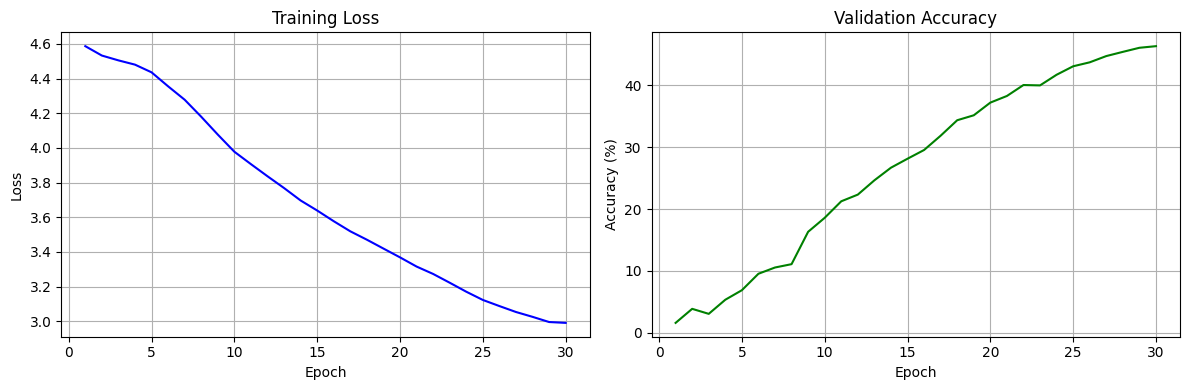

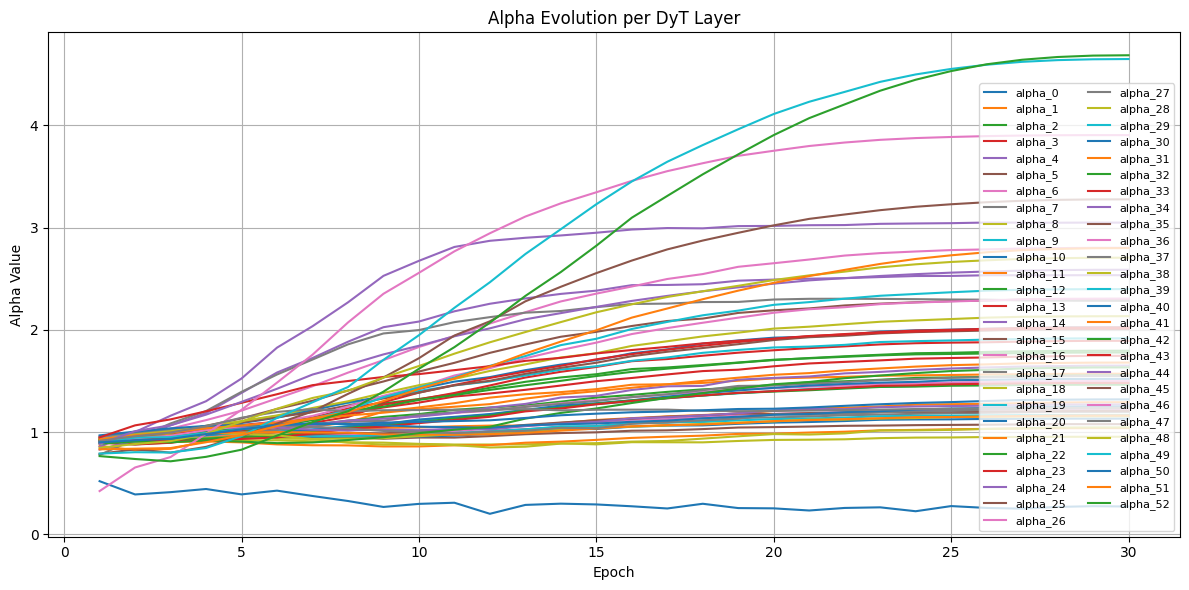

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# CSV 파일 로딩
df_main = pd.read_csv("training_curve_dyt.csv")
df_alpha = pd.read_csv("alpha_history_dyt.csv")

#  Loss & Val Accuracy 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(df_main['Epoch'], df_main['Loss'], label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(df_main['Epoch'], df_main['Val_Acc'], label='Val Acc', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

# Alpha 값 변화 시각화
plt.figure(figsize=(12, 6))
alpha_columns = [col for col in df_alpha.columns if col.startswith("alpha_")]

for col in alpha_columns:
    plt.plot(df_alpha['Epoch'], df_alpha[col], label=col)

plt.xlabel('Epoch')
plt.ylabel('Alpha Value')
plt.title('Alpha Evolution per DyT Layer')
plt.legend(fontsize=8, ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()
